In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


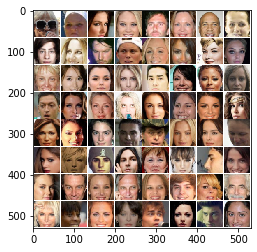

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

loaders, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)
trainloader = loaders['train']
valloader = loaders['val']

sample = next(iter(loaders['train']))
plot_grid(sample, figsize=(4, 4))
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        ft = torch.rfft(data, 2, onesided=False)
        magn = torch.sqrt(torch.sum(ft**2, -1))
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [6]:
# Define Gen and Disc loss

#def gen_loss(disc_output_generated, gen_output, x):
#    reconstruction = torch.mean(torch.abs(x-gen_output))
#    adversarial = 0.5*torch.mean((1-disc_output_generated)**2)
#    return reconstruction + adversarial

def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

#def disc_loss(disc_output_real, disc_output_generated):
#    loss_real = 0.5*torch.mean((1-disc_output_real)**2)
#    loss_generated = 0.5*torch.mean((disc_output_generated)**2)
#    return loss_real+loss_generated

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [13]:
### Create new models ###

gen = models.ConvNet(imsize=(6, 64, 64), outsize=imsize, s=64)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [14]:
# Set training parameters

history = []
g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)
lmd = 1e3 # loss signal

In [15]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_magnitudes], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 274.7657775878906
Discriminator initial loss: 0.6950850486755371


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [16]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            ft =  torch.rfft(x, 2, onesided=False)
            magnitudes = torch.sqrt(torch.sum(ft**2, -1))
            
            # stack magnitudes to noise / generator input
            z = torch.randn(*x.shape).to(device)
            zm = torch.cat([z, magnitudes], dim=1)
            
            # calc gen output
            gen.train()
            gen_output = gen(zm)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen(zm), x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, valloader)
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        torch.save(gen_weights, "../cache/Generator64CelebA_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        torch.save(disc_weights, "../cache/Discriminator64CelebA_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return history

In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, trainloader, epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/Generator64CelebA1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/Discriminator64CelebA1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:  1 	 step:0 	 loss: 638.0
epoch:  1 	 step:100 	 loss: 621.6
epoch:  1 	 step:200 	 loss: 603.8
epoch:  1 	 step:300 	 loss: 613.1


In [9]:
### LOAD MODEL ####

gen = models.ConvNet(imsize=(6, 64, 64), outsize=imsize, s=64)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("/home/shared/phase-retrieval/models/cGAN_CelebA/ConvGenerator64CelebA_7_0.014.sd", map_location={'cuda:1': device.__str__()}));
disc.load_state_dict(torch.load("/home/shared/phase-retrieval/models/cGAN_CelebA/ConvDiscriminator64CelebA_7_0.014.sd", map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [10]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, loaders['test'])
print(test_images.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(19963, 3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


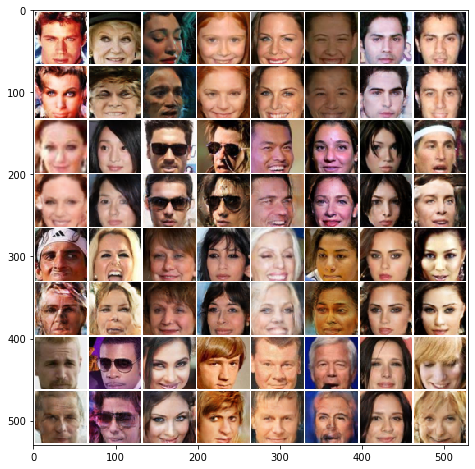

In [21]:
# Plot test predictions #

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    test_outputs[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot), figsize=(8,8), file="../out/cgan/celeba/ConvGenerator64CelebA_7_0.013.png")

In [13]:
# Benchmark test predictions #

benchmark(pred=test_outputs, true=test_images, check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.013947402113143869, std: 0.011750179361769576
  MAE: 0.08083201675111641, std: 0.0292920876308582
  SSIM: 0.6789902463579959, std: 0.1194057834179455

Magnitude error:
  MSE Magnitude: 17.234779735524448, std: 12.928992532139253

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01395 | 0.08083 | 0.6790 | 17.23 |


## Evaluation for different cGAN models (random z and full test data)

| Nr | Type | Loss | Size | epochs | MSE val | MSE test | SSIM test | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Conv | log GAN + 100 * MAE | 64 | 50 | 0.020 | 0.0203 | 0.610 | 27.0
| 2 | Conv | log GAN + 100 * MAE | 64 | 91 | 0.020 | 0.0199 | 0.613 | 26.5
| 3 | Conv | log GAN + 1e3 * MAE | 64 | 50 | 0.015 | 0.0142 | 0.677 | 17.9
| 4 | Conv | log GAN + 1e4 * MAE | 64 | 50 | 0.012 | *0.0124* | 0.709 | 15.7 | -> *Becoming blurry*
| 5 | Conv | log GAN + 1e4 * MAE | 64 | 100 | 0.013 | *0.0129* | 0.700 | 16.286
| 6 | Conv | log GAN + 1e4 * MAE | 64 | 150 | 0.013 | *0.0131* | 0.693 | 16.401
| 7 | Conv | log GAN + 1e3 * MAE | 64 | 150 | 0.014 | __0.01395__ | 0.67899 | 17.24

In [15]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check_all=True)

Signal error:
  MSE: 0.013773245887932717, std: 0.011633602146563438
  MAE: 0.08039976290092454, std: 0.028752873106164315
  SSIM: 0.6799479613429249, std: 0.11769951621929947
  Sharpness: 0.04947661704320023, std: 0.01344767931573222
  PhCo-MSE: 0.015375263428722974, std: 0.015560852350357854
  PhCo-MAE: 0.08375347838227754, std: 0.035530554840204516
  PhCo-SSIM: 0.6673538731700874, std: 0.1381149069627906
  CroCo-MSE: 0.013274564289076807, std: 0.01036833457122182
  CroCo-MAE: 0.07939728058772744, std: 0.02730354486892034
  CroCo-SSIM: 0.6803892499438662, std: 0.11827399067315776

Magnitude error:
  MSE Magnitude: 17.137866607912365, std: 13.268647647222256

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01377 | 0.08040 | 0.6799 | 0.04948 | 0.01538 | 0.08375 | 0.6674 | 0.01327 | 0.07940 | 0.6804 | 17.14 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Size | epochs | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM  | CroCo-MSE | CroCo-MAE | CroCo-SSIM  | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Conv | log GAN + 100 * MAE | 64 | 50 | 0.0200 | 0.0977 | 0.613 | | 0.0223 | 0.1019 | | 0.0190 | | | 26.493
| 2 | Conv | log GAN + 100 * MAE | 64 | 91 | 0.0197 | 0.0968 | 0.615 | | 0.0213 | 0.0999 | | 0.0187 | | | 225.962
| 3 | Conv | log GAN + 1e3 * MAE | 64 | 50 | 0.0140 | 0.0812 | 0.678 | | 0.0151 | 0.0835 | | 0.0135 | | | 217.788
| 4 | Conv | log GAN + 1e4 * MAE | 64 | 50 | *0.0125* | 0.0759 | 0.708 | | 0.0133 | 0.0777 | | 0.0118 | | | 215.856 | -> *Becoming blurry*
| 5 | Conv | log GAN + 1e4 * MAE | 64 | 100 | *0.013* | 0.0774 | 0.699 | | 0.0142 | 0.0800 | | 0.0124 | | | 216.342
| 6 | Conv | log GAN + 1e4 * MAE | 64 | 150 | *0.0133* | 0.0785 | 0.692 | | 0.0145 | 0.0810 | | 0.0126 | | | 216.579
| 7 | Conv | log GAN + 1e3 * MAE | 64 | 150 | __0.01377__ | 0.08040 | 0.6799 | 0.04948 | 0.01497 | 0.08296 | | 0.01325 | | | 217.134


In [24]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft**2, -1) + 1e-16)
    return mags

In [25]:
# Latent z optimization

def genopt(sample_magnitudes, gen, disc, device, init_x=None, max_steps=5000, max_loss=0.0, mue=1.0, lr=1.0):
    
    if disc is not None:
        disc.to(device)
        disc.eval()
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
    
    for i in range(max_steps):
        magnitudes = calc_mags(last_out)

        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=(1, 2, 3))
        reconstruction = torch.sum(mse_all)
        #adversarial = -torch.mean(torch.log(disc(torch.cat([last_out, sample_magnitudes], dim=1))))
        #loss = reconstruction + mue * adversarial
        loss = reconstruction + mue * torch.mean(z ** 2)
        
        if loss < max_loss:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all


In [ ]:
### Latent z optimization ###

num_batches = 16
max_steps = 10000
max_loss = 0.0
mue = 0.0
lr = 1.0

###

out_original = np.zeros((64 * num_batches, *imsize))
out_results = np.zeros((64 * num_batches, *imsize))
mse_all = np.full((64 * num_batches), np.inf)

for batch_i, batch in enumerate(loaders['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[64 * batch_i : 64 * batch_i + 64] = test_sample.cpu().numpy()
    

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, disc=None, device=device,
                                          max_steps=max_steps, max_loss=max_loss, mue=mue, lr=lr)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[64 * batch_i : 64 * batch_i + 64] = cur_out_results
    mse_all[64 * batch_i : 64 * batch_i + 64] = cur_mse_all.detach().cpu().numpy()

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_original_7_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_7_1024.p", "wb"))

In [26]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_original_7_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_CelebA/cgan_7_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


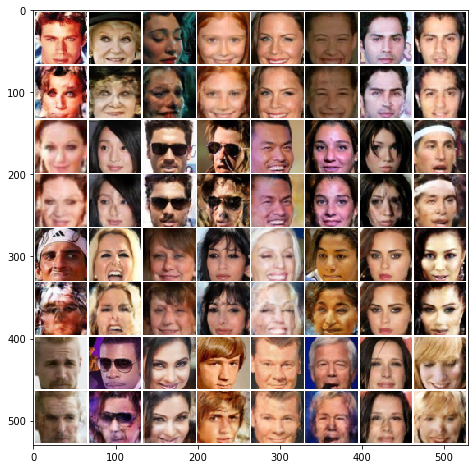

Signal error:
  MSE: 0.009290471299544375, std: 0.013154371645736131
  MAE: 0.06417114207630562, std: 0.03305448261072466
  SSIM: 0.7631490591353236, std: 0.13825365088142008
  FASI-MSE: 0.009585876336499894, std: 0.013330430504921494
  FASI-MAE: 0.06499480650670507, std: 0.03423717228701404
  COCO-MSE: 0.008461870937427009, std: 0.009545618926780271

Magnitude error:
  MSE Magnitude: 0.8488333116319923, std: 0.49897063810516734

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [27]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64),
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/celeba/ConvGenerator64CelebA_7_1024_10000latentSteps.png")

benchmark(pred=out_results, true=out_original, check_all=True)

## Evaluation for different z optimizations (64 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 0.0 | 10.0 | 0.0162 | 0.0864 | 0.661 | 0.0175 | 0.0885 | 0.0138 | 2.123
| 1 | 10000 | 0.0 | 1.0 | 0.0147 | 0.0827 | 0.678 | 0.0167 | 0.0866 | 0.0132 | 2.431
| 1 | 20000 | 0.0 | 1.0 | 0.0146 | 0.0828 | 0.678 | 0.0149 | 0.0839 | 0.0131 | 2.158
| 1 | 10000 | 1e-3 | 1.0 | 0.0148 | 0.0830 | 0.671 | 0.0176 | 0.0886 | 0.0134 | 4.392
| 1 | 10000 | 1e-1 | 1.0 | 0.0166 | 0.0889 | 0.630 | 0.0197 | 0.0949 | 0.0154 | 13.267
| 3 | 10000 | 0.0 | 1.0 | 0.0113 | 0.0722 | 0.718 | 0.0131 | 0.0754 | 0.0109 | 0.945
| 4 | 10000 | 0.0 | 1.0 | 0.0102 | 0.0678 | 0.748 | 0.0128 | 0.0726 | 0.00968 | 0.993
| 5 | 10000 | 0.0 | 1.0 | 0.0107 | 0.0683 | 0.744 | 0.0110 | 0.0691 | 0.0102 | *0.715*
| 6 | 10000 | 0.0 | 1.0 | 0.0100 | 0.0680 | 0.734 | 0.0102 | 0.0688 | 0.0096 | *0.634*
| 6 | 10000 | 0.0 | 10.0 | 0.00978 | 0.0673 | 0.739 | 0.00985 | 0.0674 | 0.00932 | *0.514*
| 7 | 10000 | 0.0 | 1.0 | 0.0114 | 0.0723 | 0.720 | 0.0121 | 0.0739 | 0.0109 | __0.938__


### Use full Generator loss (with Discriminator)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 1e-2 | 1.0 | 0.0148 | 0.0833 | 0.674 | 0.0166 | 0.0876 | 0.0133 | 2.433
| 1 | 10000 | 1e-1 | 1.0 | 0.0147 | 0.0831 | 0.672 | 0.0192 | 0.0916 | 0.0131 | 2.509
| 1 | 10000 | 00 | 1.0 | 0.0146 | 0.0825 | 0.678 | 0.0173 | 0.0875 | 0.0132 | 2.446
| 2 | 10000 | 00 | 1.0 | 0.0151 | 0.0839 | 0.669 | 0.0181 | 0.0895 | 0.0135 | 2.417

## Final Evaluation (1024 samples)

| Nr Type | iterations | mue | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 7 | 10000 | 0.0 | 1.0 | __0.009290__ | 0.06417 | 0.7631 | 0.009586 | 0.06499 | 0.008462 | 0.8488


## Test
---

In [96]:
gen.layers[19].parameters()

<generator object Module.parameters at 0x7f2fcaea9ba0>

In [99]:
### Latent optimization over Kernel layers ###

import copy

def genopt2(sample_magnitudes, gen, device, max_steps=5000, max_loss=0.0, lr=1.0):
       
    total_losses = np.full((len(sample_magnitudes), max_steps + 1), np.NAN)
    total_out = []
    
    for i, magn in enumerate(sample_magnitudes):
        magn.unsqueeze_(0)
    
        cur_model = copy.deepcopy(gen)
        cur_model.to(device)
        cur_model.eval()
        optimizer = optim.Adam(cur_model.layers[19].parameters(), lr=lr)
        
        z = torch.randn((1, *sample_magnitudes.shape[1:]), requires_grad=True, device=device)
        
        last_out = cur_model(torch.cat([z, magn], dim=1))
        pred_magn = calc_mags(last_out)
        loss = torch.mean((pred_magn - magn) ** 2)
        
        losses = [loss]
        best_out = last_out
        best_loss = np.Inf
        
        for j in range(max_steps):

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_out = cur_model(torch.cat([z, magn], dim=1))
            pred_magn = calc_mags(last_out)
            loss = torch.mean((pred_magn - magn) ** 2)
            
            losses.append(loss.item())
            if loss < best_loss:
                best_loss = loss
                best_out = last_out.detach().cpu().numpy()
            if loss < max_loss:
                break
 
        total_losses[i, :(j+2)] = losses
        total_out.append(best_out)
        print("Iteration {} finished in {} steps".format(i + 1, j + 1))
        
    return np.vstack(total_out), total_losses

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Iteration 1 finished in 3000 steps
Iteration 2 finished in 3000 steps
Iteration 3 finished in 3000 steps
Iteration 4 finished in 3000 steps
Iteration 5 finished in 3000 steps
Iteration 6 finished in 3000 steps
Iteration 7 finished in 3000 steps
Iteration 8 finished in 3000 steps
Iteration 9 finished in 3000 steps
Iteration 10 finished in 3000 steps
Iteration 11 finished in 3000 steps
Iteration 12 finished in 3000 steps
Iteration 13 finished in 3000 steps
Iteration 14 finished in 3000 steps
Iteration 15 finished in 3000 steps
Iteration 16 finished in 3000 steps
Iteration 17 finished in 3000 steps
Iteration 18 finished in 3000 steps
Iteration 19 finished in 3000 steps
Iteration 20 finished in 3000 steps
Iteration 21 finished in 3000 steps
Iteration 22 finished in 3000 steps
Iteration 23 finished in 3000 steps
Iteration 24 finished in 3000 steps
Iteration 25 finished in 3000 steps
Iteration 26 finished in 3000 steps
Iteration 27 finished in 3000 steps
Iteration 28 finished in 3000 steps
I

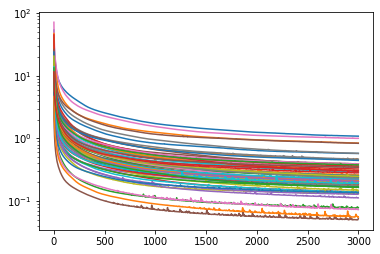

In [129]:
### Latent z optimization ###

num_batches = 1
batch_size = 64
max_steps = 3000
max_loss = 0.0
lr = 1e-5

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))

for batch_i, batch in enumerate(loaders['test']):
    test_sample = batch[:batch_size].to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    cur_out_results, cur_loss = genopt2(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                          max_steps=max_steps, max_loss=max_loss, lr=lr)
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break
    
plt.semilogy(cur_loss.T)
print(cur_loss.T[-1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


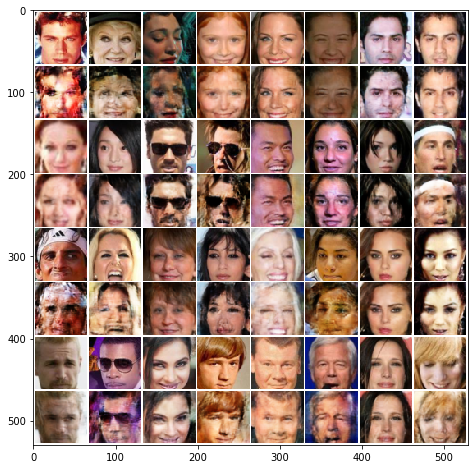

Signal error:
  MSE: 0.010675231664305024, std: 0.010149683790257949
  MAE: 0.07091965287206325, std: 0.030631606479126987
  SSIM: 0.7269903305318637, std: 0.14344731589951554
  FASI-MSE: 0.010888511886530509, std: 0.010834469252662753
  FASI-MAE: 0.0715438382401622, std: 0.032551092648563026
  COCO-MSE: 0.010039793203768022, std: 0.009504044373383902

Magnitude error:
  MSE Magnitude: 0.2932612311107514, std: 0.20227016853038285

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [131]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64),
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/celeba/ConvGenerator64CelebA_6_3000kernSteps.png")

benchmark(pred=out_results, true=out_original, check_all=True)

## Evaluation for different kern optimizations (64 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 6 | 3000 | 1e-5 | 0.0106 | 0.0709 | 0.726 | 0.0108 | 0.0715 | 0.0100 | 0.293
| 7 | 3000 | 1e-5 |

## Archive:
---

In [29]:
benchmark(pred=all_results, true=test_sample.cpu().numpy(), check=["mse", "fasi", "coco", "magn", "imcon"])

Signal error:
  MSE: 0.013637370091601042, std: 0.00911265887314466
  FASI-MSE: 0.016154480432305718, std: 0.014727767961808509
  COCO-MSE: 0.012994797515406376, std: 0.008551907895572189

Magnitude error:
  MSE Magnitude: 21.795072591884317, std: 11.469337157458362

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [30]:
benchmark(pred=test_outputs[0:100], true=test_sample.cpu().numpy(), check=["mse", "fasi", "coco", "magn", "imcon"])

Signal error:
  MSE: 0.01414842382655479, std: 0.009164059985266633
  FASI-MSE: 0.017445878649596125, std: 0.01635206752016813
  COCO-MSE: 0.013535243754046473, std: 0.008579297436035008

Magnitude error:
  MSE Magnitude: 26.40082371572398, std: 16.072484393244824

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


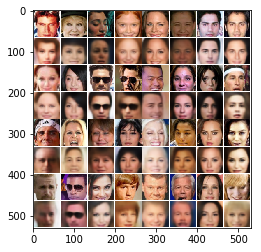

In [34]:

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    test_outputs[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


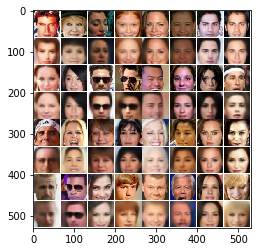

In [38]:

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    all_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot), file='/home/shared/phase-retrieval/out/cgan/cgan_CelebA.pdf')

In [39]:
benchmark(pred=test_outputs, true=test_images, check=["mse", "fasi", "coco", "magn", "imcon"])

Signal error:
  MSE: 0.013851174056045131, std: 0.01123683670025322
  FASI-MSE: 0.01612766239571939, std: 0.01592583251915383
  COCO-MSE: 0.012826716958438136, std: 0.00847966661115639

Magnitude error:
  MSE Magnitude: 24.507859597420737, std: 15.69752536565758

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


Sum validation results

Old CelebA crop:

| Type | Loss | Size | epochs | MSE train | MSE val
| --- | --- | --- | --- | --- | --- |
| FC + Batch Norm | MSE image | 2048 | 1 | 0.026 | 0.024 |
| FC + Batch Norm | MSE image | 2048 | 10 | 0.014 | 0.018 |
| FC + Batch Norm | MSE image | 2048 | 30 | 0.0085 | 0.016 |
| FC + Batch Norm | MSE image | 2048 | 50 | 0.0075 | 0.0168 |
| FC + Batch Norm | MSE image | 2048 | 70 | 0.0062 | 0.017 |


New CelebA crop:

| Type | Loss | Size | epochs | MSE train | MSE val | FASI val | COCO val |
| --- | --- | --- | --- | --- | --- | --- | --- |
| FC + Batch Norm | MSE image | 2048 | 30 | 0.0086 | 0.0121 | 0.0128 | 0.0112
| Conv | cGAN | ... | 25 | 0.0086 | 0.0121 | 0.0128 | 0.0112